### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data
https://www.kaggle.com/datasets/surajjha101/cuisine-rating

---
##### Data Dictionary

    User ID - User ID of customers
    Area code - Area code of customers residence
    Location - Area and the city of residence of customers
    Gender - Gender of customer
    YOB - Year when customer was born
    Marital Status - Marital status
    Activity - Customers career status whether student or professional
    Budget - Budget they may spend in the restaurant
    Cuisines - Cuisine they preferred/liked the most to have at restaurant
    Alcohol - Alcohol intake frequency
    Food Rating - Rating they gave to restaurant's food
    Service Rating - Rating they gave to restaurant's service
    Overall Rating - Mean rating calculated from food and service ratings
    Often A S - Often they visited restaurant or not
---

In [2]:
df = pd.read_csv("../../DATA/kaggle/cuisine_rating.csv")
df.head()

,User ID,Area code,Location,Gender,YOB,Marital Status,Activity,Budget,Cuisines,Alcohol,Smoker,Food Rating,Service Rating,Overall Rating,Often A S
0,1,153,"Upper East Side,NY",Female,2006,Single,Professional,3,Japanese,Never,Never,5,4,4.5,No
1,2,123,"St. George,NY",Female,1991,Married,Student,3,Indian,Never,Socially,1,1,1.0,No
2,3,122,"Upper West Side,NY",Male,1977,Single,Student,5,Seafood,Often,Often,5,5,5.0,Yes
3,4,153,"Upper East Side,NY",Female,1956,Married,Professional,5,Japanese,Never,Socially,3,1,2.0,No
4,5,129,"Central Park,NY",Male,1997,Single,Student,4,Filipino,Socially,Never,2,4,3.0,No


## Goal definition
**What rating does a cuisine dish get?**\
\
The problem refers to regression, that is, to predict the numerical value of an Food Rating.

## Exploratory Data Analysis and Visualisations - IMPORTANT NOTE!
Full EDA process was performed in another file (*EDA_cuisine_raring.ipynb*), so here that process is skipped. The file is located in the same repository in the *Projects/EDA* folder. This section applies only to additional visualizations for problem solving.

#### Budget impact on food rating

<Axes: xlabel='Food Rating', ylabel='Budget'>

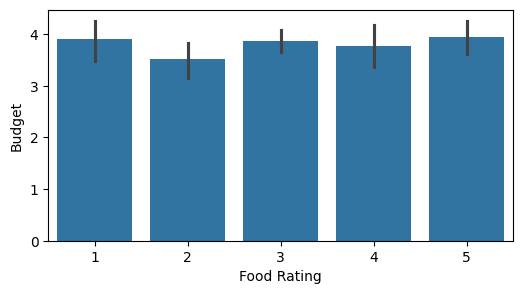

In [3]:
plt.figure(figsize=(6,3))
sns.barplot(data=df, x='Food Rating', y='Budget')

##### Conclusions
Budget does not have much impact on the food rating

## Modeling

### Data preparation

In [4]:
evaluation_dict = {}

In [5]:
df_dummies = pd.get_dummies(df, drop_first=True)

### Train | Test Split

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X = df_dummies.drop('Food Rating', axis=1)
y = df_dummies['Food Rating']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101)

## Random Forest Model

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [10]:
rf_model = RandomForestRegressor(bootstrap=True, oob_score=True)

In [11]:
n_estimators = [50,100,150]
param_grid = {'n_estimators': n_estimators}

In [12]:
rf_grid_model = GridSearchCV(rf_model, param_grid)

In [13]:
rf_grid_model.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(oob_score=True),
             param_grid={'n_estimators': [50, 100, 150]})

In [14]:
rf_grid_model.best_params_

{'n_estimators': 50}

### Evaluation

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

In [16]:
y_pred = rf_grid_model.predict(X_test)

In [17]:
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = root_mean_squared_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)

In [18]:
print(f" MAE = {MAE:.4f},\n", f"MSE = {MSE:.4f},\n", f"RMSE = {RMSE:.4f},\n", f"R2 = {R2:.4f}")

 MAE = 0.0873,
 MSE = 0.0147,
 RMSE = 0.1214,
 R2 = 0.9910


In [19]:
evaluation_dict['Random Forest'] =  {"MAE": MAE, "MSE": MSE, "RMSE": RMSE, "R2": R2}

#### Overfitting check

In [20]:
train_r2 = rf_grid_model.score(X_train, y_train)  # R² on training set
test_r2 = rf_grid_model.score(X_test, y_test) # R² on testing set

print(f"R² on training set: {train_r2:.4f}")
print(f"R² on testing set: {test_r2:.4f}")

R² on training set: 0.9935
R² on testing set: 0.9910


#### Residuals

In [21]:
test_residuals = y_test - y_pred

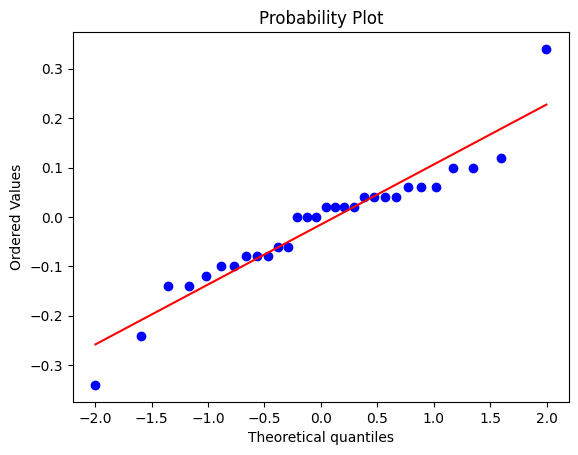

In [22]:
import scipy as sp
fig, ax = plt.subplots()
_ = sp.stats.probplot(test_residuals, plot=ax)

## SVR

### Data Scaling

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

### Model

In [25]:
from sklearn.svm import SVR

In [26]:
svr_model = SVR()
param_grid = {
    'C': [0.001,0.01,0.1,0.5,1],
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.5, 1]
}

In [27]:
svr_grid_model = GridSearchCV(svr_model, param_grid)

In [28]:
svr_grid_model.fit(scaled_X_train, y_train)

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1], 'degree': [2, 3, 4],
                         'epsilon': [0.1, 0.5, 1], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']})

In [29]:
svr_grid_model.best_estimator_

SVR(C=0.5, degree=2, kernel='linear')

### Evaluation

In [30]:
y_pred = svr_grid_model.predict(scaled_X_test)

In [31]:
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = root_mean_squared_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)

In [32]:
print(f" MAE = {MAE:.4f},\n", f"MSE = {MSE:.4f},\n", f"RMSE = {RMSE:.4f},\n", f"R2 = {R2:.4f}")

 MAE = 0.0518,
 MSE = 0.0036,
 RMSE = 0.0604,
 R2 = 0.9978


In [33]:
evaluation_dict['SVR'] =  {"MAE": MAE, "MSE": MSE, "RMSE": RMSE, "R2": R2}

#### Overfitting check

In [34]:
train_r2 = svr_grid_model.score(scaled_X_train, y_train)  # R² on training set
test_r2 = svr_grid_model.score(scaled_X_test, y_test) # R² on testing set

print(f"R² on training set: {train_r2:.4f}")
print(f"R² on testing set: {test_r2:.4f}")

R² on training set: 0.9979
R² on testing set: 0.9978


#### Residuals

In [35]:
test_residuals = y_test - y_pred

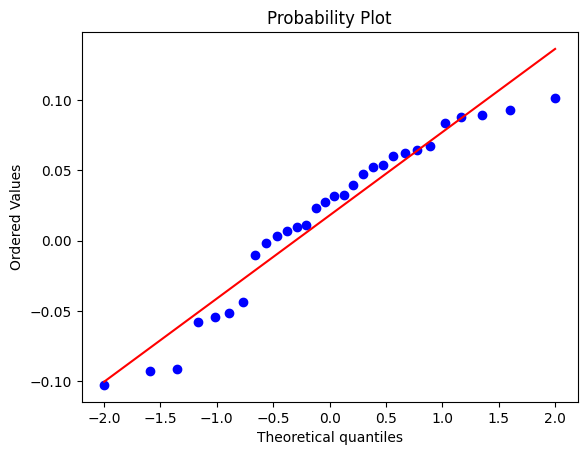

In [36]:
import scipy as sp
fig, ax = plt.subplots()
_ = sp.stats.probplot(test_residuals, plot=ax)

## AdaBoost

### Model

In [37]:
from sklearn.ensemble import AdaBoostRegressor

In [38]:
adaboost_model = AdaBoostRegressor()

In [39]:
n_estimators = [50,100,150,200,300]
loss = ['linear', 'square', 'exponential']

param_grid = {
    'n_estimators': n_estimators,
    'loss': loss
}

In [40]:
ada_grid_model = GridSearchCV(adaboost_model, param_grid)

In [41]:
ada_grid_model.fit(X_train,y_train)

GridSearchCV(estimator=AdaBoostRegressor(),
             param_grid={'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [50, 100, 150, 200, 300]})

In [42]:
ada_grid_model.best_params_

{'loss': 'square', 'n_estimators': 150}

### Evaluation

In [43]:
y_pred = ada_grid_model.predict(X_test)

In [44]:
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = root_mean_squared_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)

In [45]:
print(f" MAE = {MAE:.4f},\n", f"MSE = {MSE:.4f},\n", f"RMSE = {RMSE:.4f},\n", f"R2 = {R2:.4f}")

 MAE = 0.2780,
 MSE = 0.1095,
 RMSE = 0.3309,
 R2 = 0.9332


In [46]:
evaluation_dict['AdaBoost'] =  {"MAE": MAE, "MSE": MSE, "RMSE": RMSE, "R2": R2}

#### Overfitting check

In [47]:
train_r2 = ada_grid_model.score(X_train, y_train)  # R² on training set
test_r2 = ada_grid_model.score(X_test, y_test) # R² on testing set

print(f"R² on training set: {train_r2:.4f}")
print(f"R² on testing set: {test_r2:.4f}")

R² on training set: 0.9378
R² on testing set: 0.9332


#### Residuals

In [48]:
test_residuals = y_test - y_pred

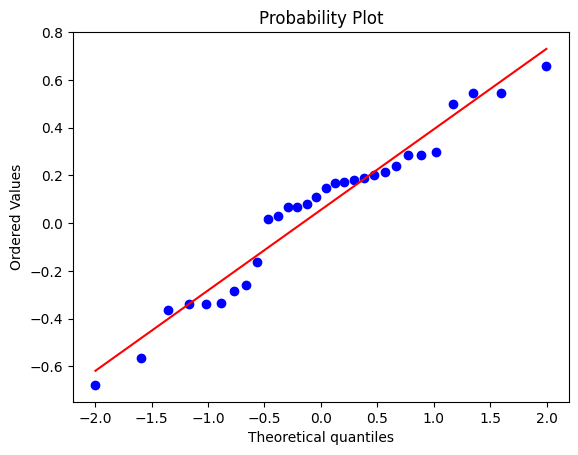

In [49]:
import scipy as sp
fig, ax = plt.subplots()
_ = sp.stats.probplot(test_residuals, plot=ax)

## Gradient Boosting

### Model

In [50]:
from sklearn.ensemble import GradientBoostingRegressor

In [51]:
gb_model = GradientBoostingRegressor()

In [52]:
n_estimators = [10,50,100,150,200]
max_depth = [2,3,4,5,6]

param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth
}

In [53]:
gb_grid_model = GridSearchCV(gb_model, param_grid)

In [54]:
gb_grid_model.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'n_estimators': [10, 50, 100, 150, 200]})

In [55]:
gb_grid_model.best_params_

{'max_depth': 2, 'n_estimators': 200}

### Evaluation

In [56]:
y_pred = gb_grid_model.predict(X_test)

In [57]:
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = root_mean_squared_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)

In [58]:
print(f" MAE = {MAE:.4f},\n", f"MSE = {MSE:.4f},\n", f"RMSE = {RMSE:.4f},\n", f"R2 = {R2:.4f}")

 MAE = 0.0535,
 MSE = 0.0053,
 RMSE = 0.0726,
 R2 = 0.9968


In [59]:
evaluation_dict['Gradient Boosting'] =  {"MAE": MAE, "MSE": MSE, "RMSE": RMSE, "R2": R2}

#### Overfitting check

In [60]:
train_r2 = gb_grid_model.score(X_train, y_train)  # R² on training set
test_r2 = gb_grid_model.score(X_test, y_test) # R² on testing set

print(f"R² on training set: {train_r2:.4f}")
print(f"R² on testing set: {test_r2:.4f}")

R² on training set: 0.9989
R² on testing set: 0.9968


#### Residuals

In [61]:
test_residuals = y_test - y_pred

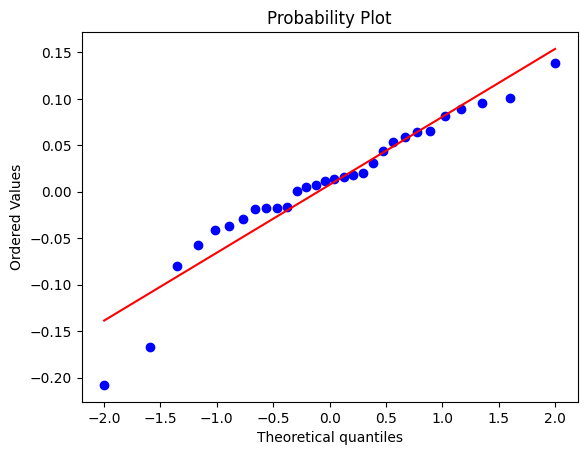

In [62]:
import scipy as sp
fig, ax = plt.subplots()
_ = sp.stats.probplot(test_residuals, plot=ax)

## Models comparison

In [63]:
df_evaluation = pd.DataFrame(evaluation_dict).T.sort_values(by="R2", ascending=False)
df_evaluation

,MAE,MSE,RMSE,R2
SVR,0.051804,0.003646,0.060384,0.997777
Gradient Boosting,0.053512,0.005270,0.072595,0.996787
Random Forest,0.087333,0.014733,0.121381,0.991016
AdaBoost,0.278024,0.109516,0.330932,0.933222


#### Conclusions
- **SVR** has the lowest MAE, MSE, and RMSE, and the highest R² score, suggesting it provides the best overall performance among the tested models.
- **Gradient Boosting** and **Random Forest** are quite close to SVR, with only slightly worse performance.
- **AdaBoost** performs significantly worse, especially with much higher MAE, MSE, and RMSE, and a much lower R².

The results on the training and test data are almost identical for each model, which means that the models generalize well and are not over-fitted to the training data. The biggest difference can be seen da AdaBoost, while it is still a small difference ($0.9573 - 0.9431 = 0.0142$)

## Final Model

In [64]:
import joblib

In [65]:
joblib.dump(svr_grid_model, '../Models_joblib/Regression_cuisine_rating_FINAL.joblib')

['../Models_joblib/Regression_cuisine_rating_FINAL.joblib']

In [66]:
model_loaded = joblib.load('../Models_joblib/Regression_cuisine_rating_FINAL.joblib')
prediction = model_loaded.predict(scaled_X_test)

MAE = mean_absolute_error(y_test, prediction)
MSE = mean_squared_error(y_test, prediction)
RMSE = root_mean_squared_error(y_test, prediction)
R2 = r2_score(y_test, prediction)

print(f" MAE = {MAE:.4f},\n", f"MSE = {MSE:.4f},\n", f"RMSE = {RMSE:.4f},\n", f"R2 = {R2:.4f}")

 MAE = 0.0518,
 MSE = 0.0036,
 RMSE = 0.0604,
 R2 = 0.9978
